In [1]:
%matplotlib inline

import sgp4
import sgp4.io
import sgp4.earth_gravity

import urllib.request
import http.cookiejar

import numpy as np
import matplotlib.pyplot as plt

# Larger figure size
fig_size = [14, 10]
plt.rcParams['figure.figsize'] = fig_size

In [2]:
def opener_spacetrack(username, password):
    # todo: clean login info from ipynb file
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    auth_url = 'https://www.space-track.org/ajaxauth/login/'
    auth_data = urllib.parse.urlencode({'identity' : username, 'password' : password}).encode('utf-8')
    auth_req = urllib.request.Request(auth_url, auth_data)
    r = opener.open(auth_req)
    return opener

In [3]:
def get_tles(norad_id, opener):
    url = 'https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/%3E2017-01-01/NORAD_CAT_ID/{}/orderby/EPOCH%20ASC/format/tle'.format(norad_id)
    r = opener.open(url)
    tle_lines = r.read().decode('ascii').split('\r\n')
    return [sgp4.io.twoline2rv(*x, whichconst=sgp4.earth_gravity.wgs72) for x in zip(tle_lines[::2], tle_lines[1::2])]

In [4]:
seconds_in_day = 24*3600

def prediction_error(tle1, tle2):
    x1, x2 = (t.propagate(year = tle2.epochyr, day = tle2.epochdays)[0] for t in (tle1, tle2))
    return 1e3*np.sqrt(sum((x1[j] - x2[j])**2 for j in range(3)))

def time_difference(tle1, tle2): # in days
    return (tle2.jdsatepoch - tle1.jdsatepoch)

def tle_variation(tle1, tle2):
    time = time_difference(tle1, tle2)*seconds_in_day
    if time == 0:
        return np.nan
    return prediction_error(tle1, tle2)/time

def compute_variation(tles):
    variations = np.array([tle_variation(*x) for x in zip(tles[:-1], tles[1:])])
    times = np.array([t.epochdays for t in tles[1:]])
    filt = ~np.isnan(variations)
    return (times[filt], variations[filt])

def compute_errors(tles):
    l = len(tles)
    times = [time_difference(tles[j], tles[k]) for j in range(l) for k in range(j+1,l)]
    errors = [prediction_error(tles[j], tles[k]) for j in range(l) for k in range(j+1,l)]
    return (times, errors)

def plot_variation(var, **kwargs):
    return plt.semilogy(var[0], var[1], **kwargs)

def plot_errors(err, **kwargs):
    return plt.loglog(err[0], err[1], ',', **kwargs)

In [5]:
with open('spacetrack_auth', 'r') as f:
    username, password = f.read().split('\n')[:2]
    opener = opener_spacetrack(username, password)

In [6]:
satellites = { 7530 : 'AO-7', 24278 : 'FO-29', 27607 : 'SO-50', 30776 : 'FALCONSAT-3', 39444 : 'AO-73', 40074 : 'UKUBE-1', 40903 : 'XW-2A', 40911 : 'XW-2B', 40906 : 'XW-2C', 40907 : 'XW-2D', 40910 : 'XW-2F', 40908 : 'LilacSat-2', 42017 : 'NAYIF-1', 42725 : 'LilacSat-1', 42761 : 'CAS-4A', 42759 : 'CAS-4B'}

In [7]:
tles = {k : get_tles(k, opener) for k in satellites}

In [8]:
variations = {k : compute_variation(tles[k]) for k in satellites}

In [9]:
errors = {k : compute_errors(tles[k]) for k in satellites}

In [10]:
def plot_graph(ids, **kwargs):
    [plot_variation(variations[k], **kwargs) for k in ids]
    plt.legend([satellites[k] for k in ids])
    plt.ylabel('TLE variation (m/s)')
    plt.xlabel('Time since 2017-01-01 (days)')

def plot_graph_errs(ids):
    [plot_errors(errors[k], alpha = 0.1) for k in ids]
    leg = plt.legend([satellites[k] for k in ids])
    for l in leg.get_lines():
        l.set_alpha(1)
        l.set_marker('.')
    plt.ylabel('Error in prediction (m)')
    plt.xlabel('TLE age (days)')

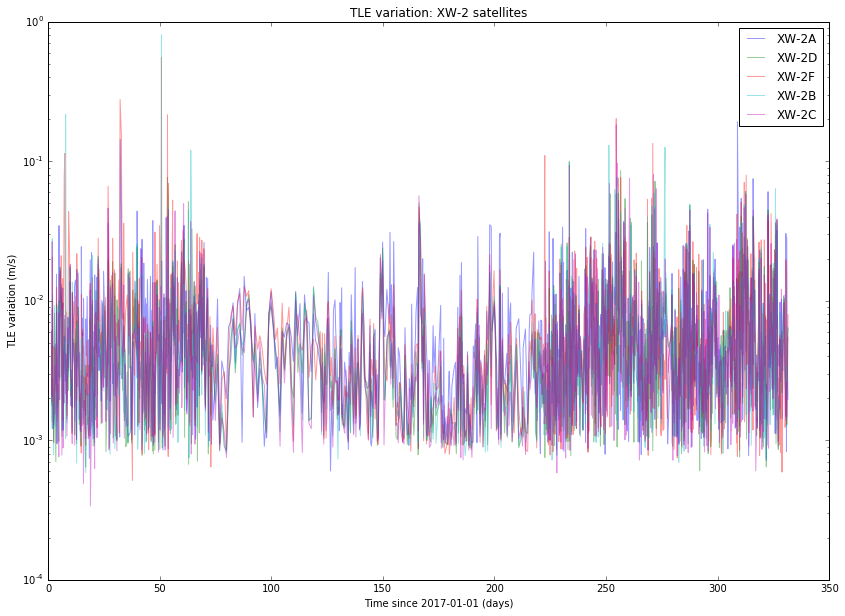

In [11]:
xws = [k for (k,v) in satellites.items() if v.startswith('XW-2')]
plot_graph(xws, alpha = 0.4)
plt.title('TLE variation: XW-2 satellites');

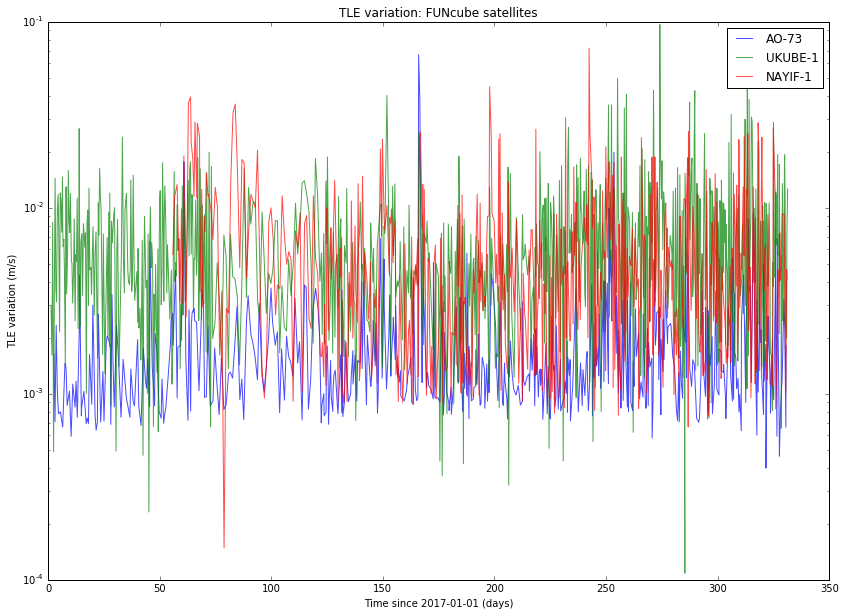

In [12]:
plot_graph([39444, 40074, 42017], alpha = 0.7)
plt.title('TLE variation: FUNcube satellites');

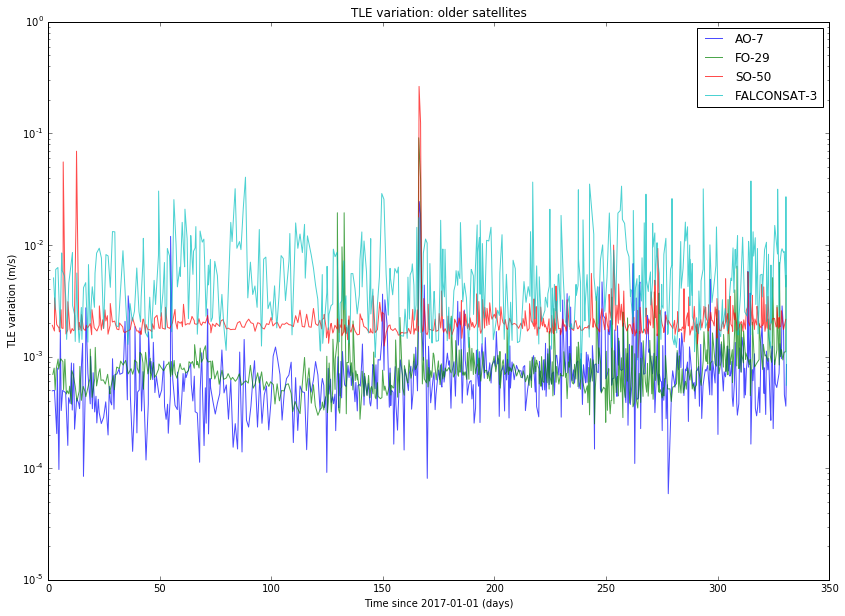

In [13]:
plot_graph([7530, 24278, 27607, 30776], alpha = 0.7)
plt.title('TLE variation: older satellites');

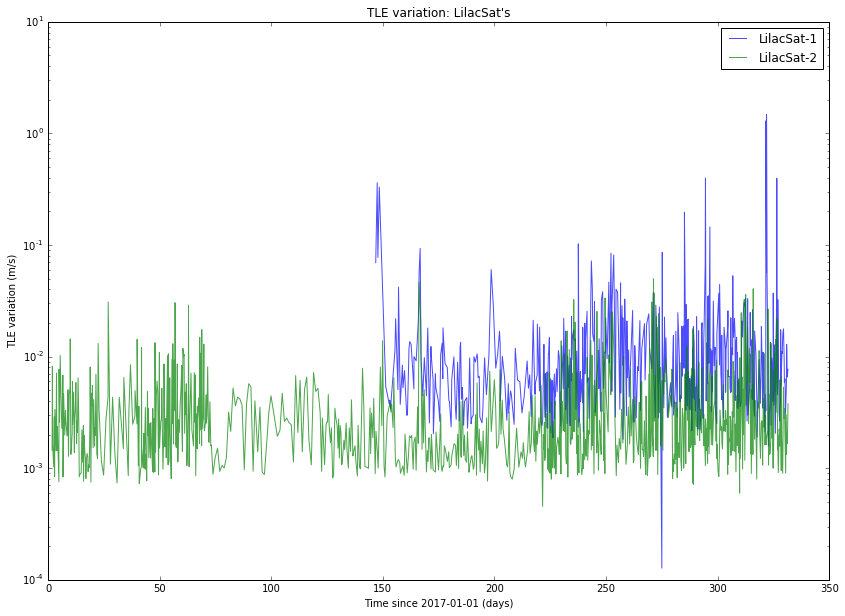

In [14]:
lilac = [k for (k,v) in satellites.items() if v.startswith('LilacSat-')]
plot_graph(lilac, alpha = 0.7)
plt.title('TLE variation: LilacSat\'s');

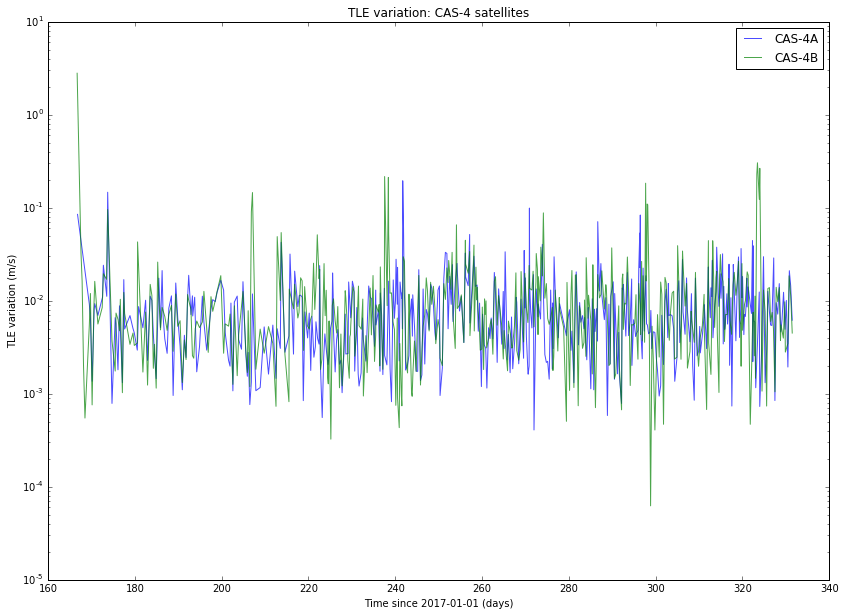

In [15]:
cas = [k for (k,v) in satellites.items() if v.startswith('CAS-4')]
plot_graph(cas, alpha = 0.7)
plt.title('TLE variation: CAS-4 satellites');

In [16]:
leo_orbital_vel = 7.8e3 # m/s
day_in_secs = 3600 * 24 # s
variation = 1e-2
delta_per_day = variation * day_in_secs / leo_orbital_vel
delta_per_day

0.11076923076923077

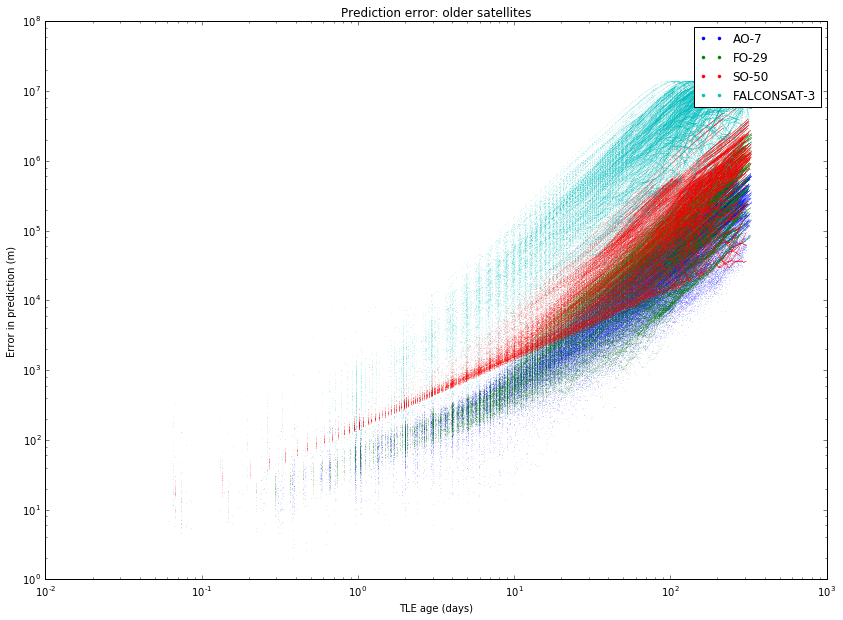

In [18]:
plot_graph_errs([7530, 24278, 27607, 30776])
plt.title('Prediction error: older satellites');

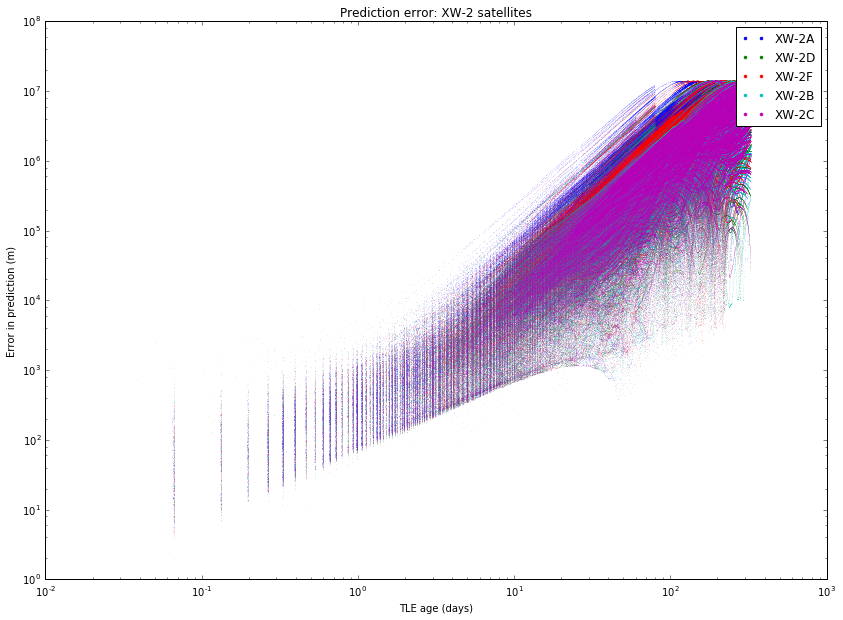

In [19]:
plot_graph_errs(xws)
plt.title('Prediction error: XW-2 satellites');

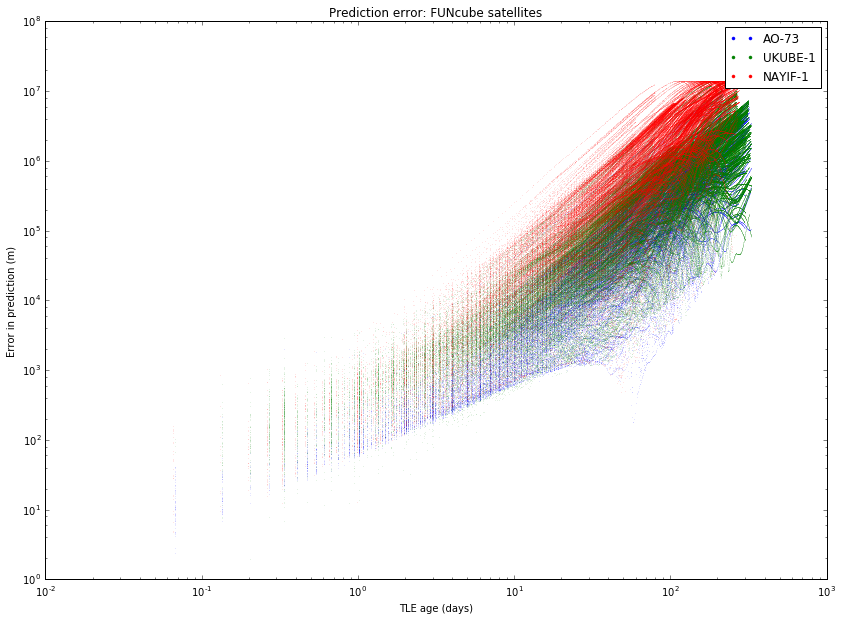

In [20]:
plot_graph_errs([39444, 40074, 42017])
plt.title('Prediction error: FUNcube satellites');

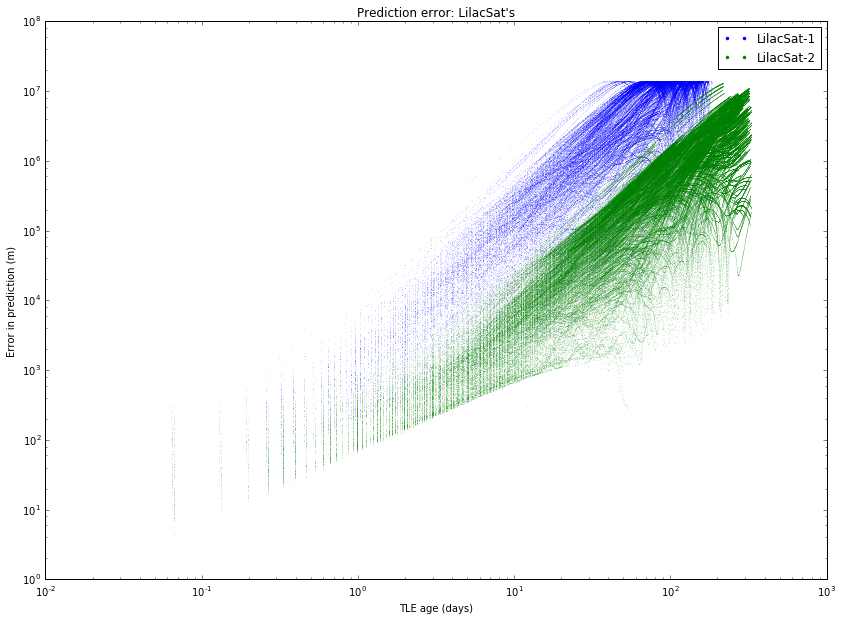

In [21]:
plot_graph_errs(lilac)
plt.title('Prediction error: LilacSat\'s');

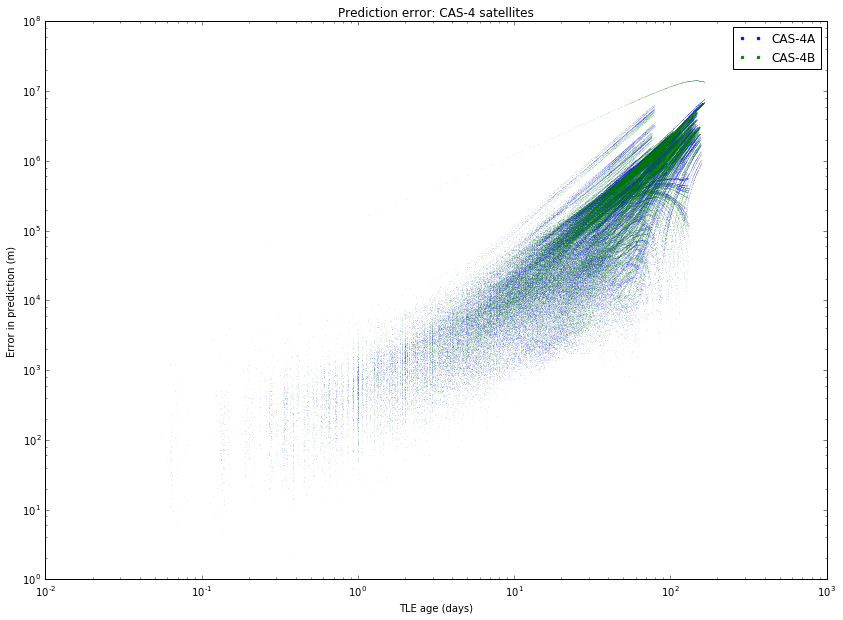

In [22]:
plot_graph_errs(cas)
plt.title('Prediction error: CAS-4 satellites');

In [27]:
def lsq_slope(ids):
    X = np.concatenate(list(map(lambda k: np.stack(map(np.array, errors[k])), ids)), axis=1)
    sel = (1 < X[0,:]) & (X[0,:] < 10)
    Y = np.log(X[:,sel])
    Z = np.vstack((np.ones(Y.shape[1]), Y))
    lsq = np.linalg.lstsq(Z[:-1,:].T, Z[2].T)
    plt.plot(Y[0], Y[1], ',', alpha = 0.1)
    plt.plot(np.sort(Y[0]), lsq[0][1]*np.sort(Y[0]) + lsq[0][0], 'r')
    plt.title('Loglog slope for prediction error between 1 and 10 days')
    plt.xlabel('log(age)')
    plt.ylabel('log(error)')
    return lsq[0][1]

1.5276691781826179

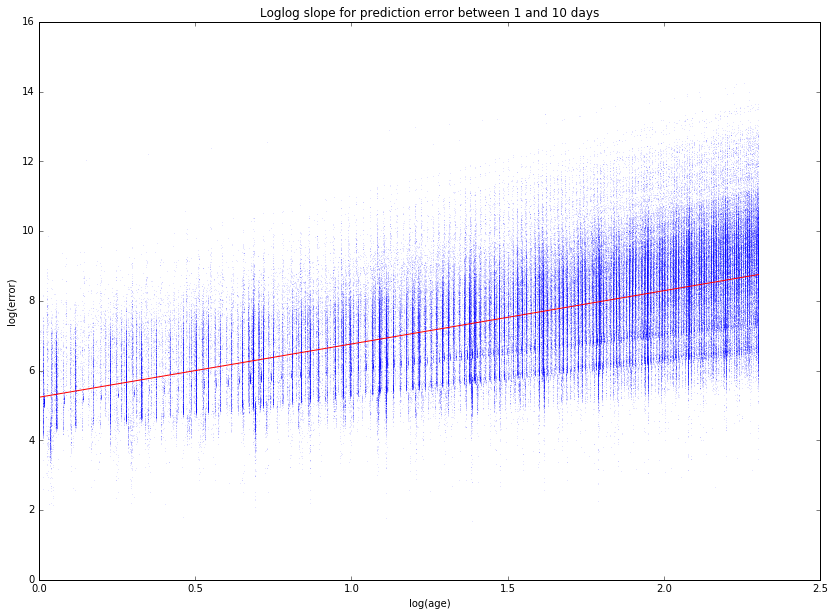

In [28]:
lsq_slope(satellites)